# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### Boilerplate

In [136]:
import numpy as np
import awkward as ak

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture

from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.plotting import plot_sim_reco, plot_tracksters, plot_dendrogram
from reco.energy import get_total_energy
from reco.data import get_bary_data, get_lc_data, get_event_data, clusters_by_indices

from reco.evaluation import evaluate, evaluate_remapped, baseline_evaluation, f_score

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_1.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [137]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

### Extract the event data

In [138]:
eid = 0

t_indexes = trackster_data["vertices_indexes"][eid]
t_multiplicity = trackster_data["vertices_multiplicity"][eid]

# simulation
st_indexes = simtrackster_data["stsSC_vertices_indexes"][eid]
st_multiplicity = simtrackster_data["stsSC_vertices_multiplicity"][eid]

t_x, t_y, t_z, t_energy = clusters_by_indices(cluster_data, t_indexes, eid)
st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indexes, eid)

nhits = cluster_data["cluster_number_of_hits"][eid]

### Input evaluation

Tracksters reco: 71, tracksters sim: 10
Simulated energy: 3313.44 GeV, reconstructed energy: 3020.35 GeV (91.15%)


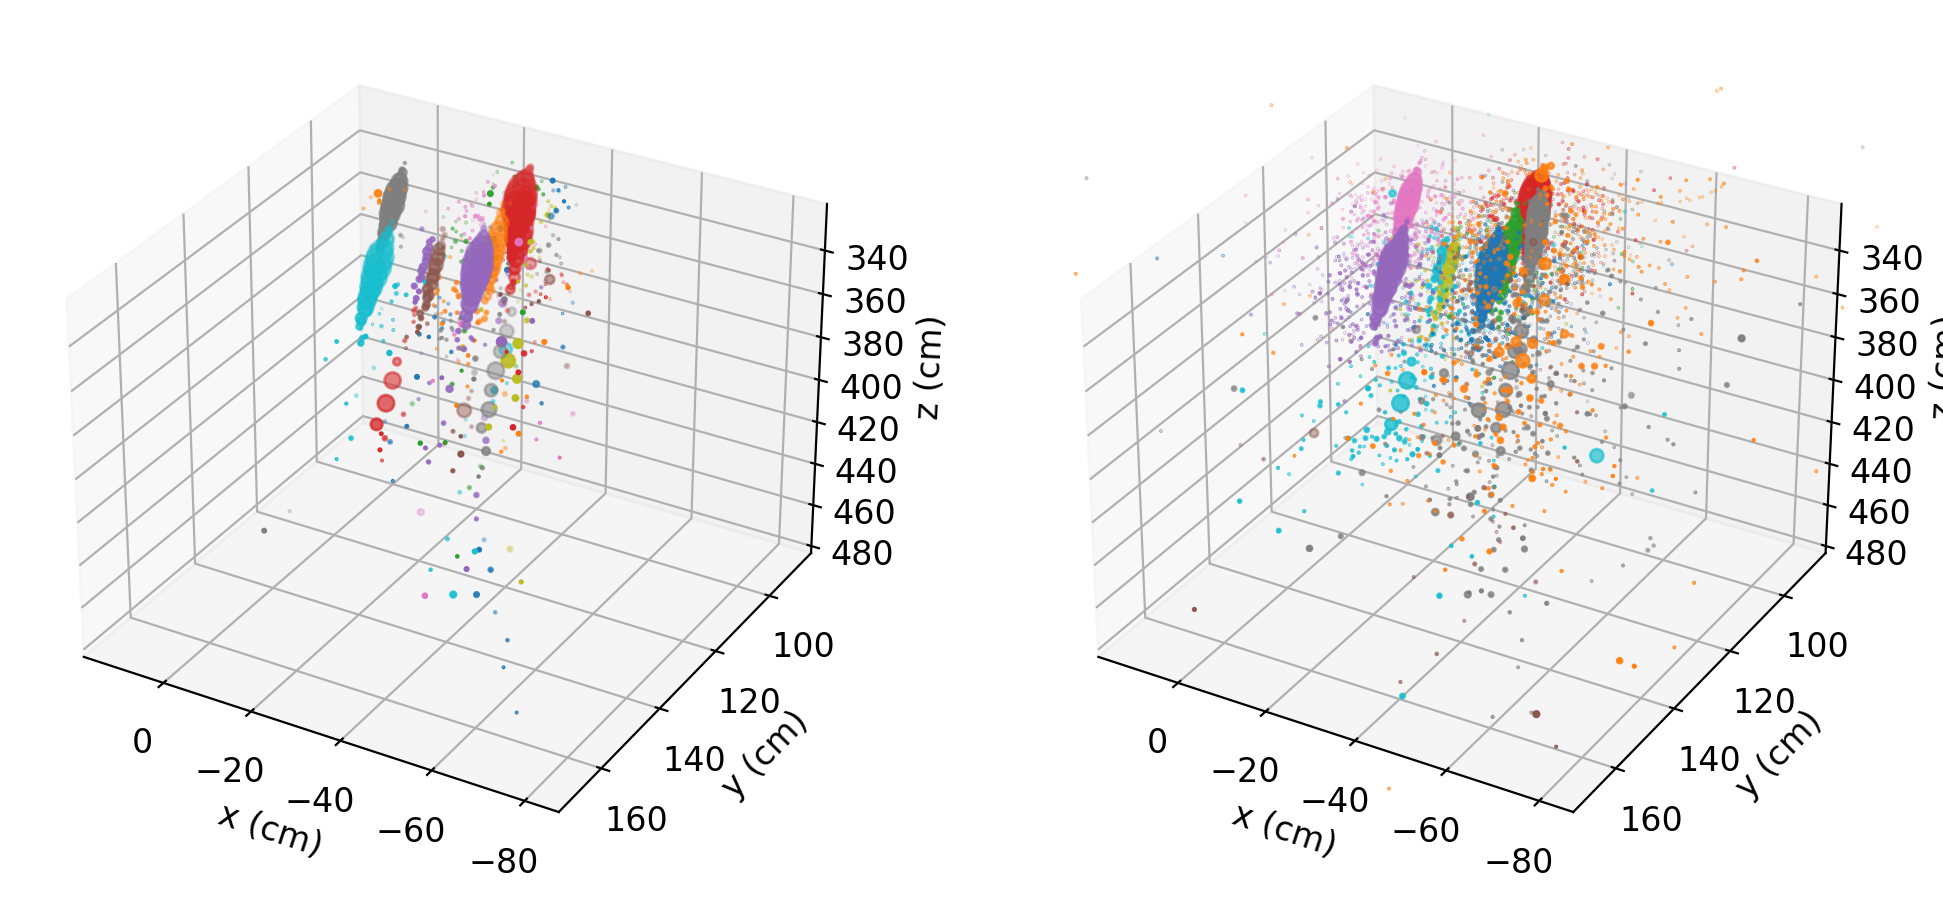

In [139]:
print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, t_multiplicity)
sim_total = get_total_energy(st_energy, st_multiplicity)
print(f"Simulated energy: {sim_total:.2f} GeV, reconstructed energy: {reco_total:.2f} GeV ({(reco_total / sim_total) * 100:.2f}%)")

ax1, ax2 = plot_sim_reco(
    t_x,
    t_y,
    t_z,
    t_energy,
    st_x,
    st_y,
    st_z,
    st_energy, 
    st_indexes,
    st_multiplicity,
)

In [140]:
precision, recall, fscore = evaluate(
    nhits,
    t_indexes,
    st_indexes,
    t_energy,
    st_energy,
    t_multiplicity,
    st_multiplicity
)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.85, Recall: 0.07, F-score: 0.58


### k-means

Apply k-means algorithm on CLUE3D barycentres

In: 71 Out: 14 Precision: 0.80, Recall: 0.17, F-score: 0.71


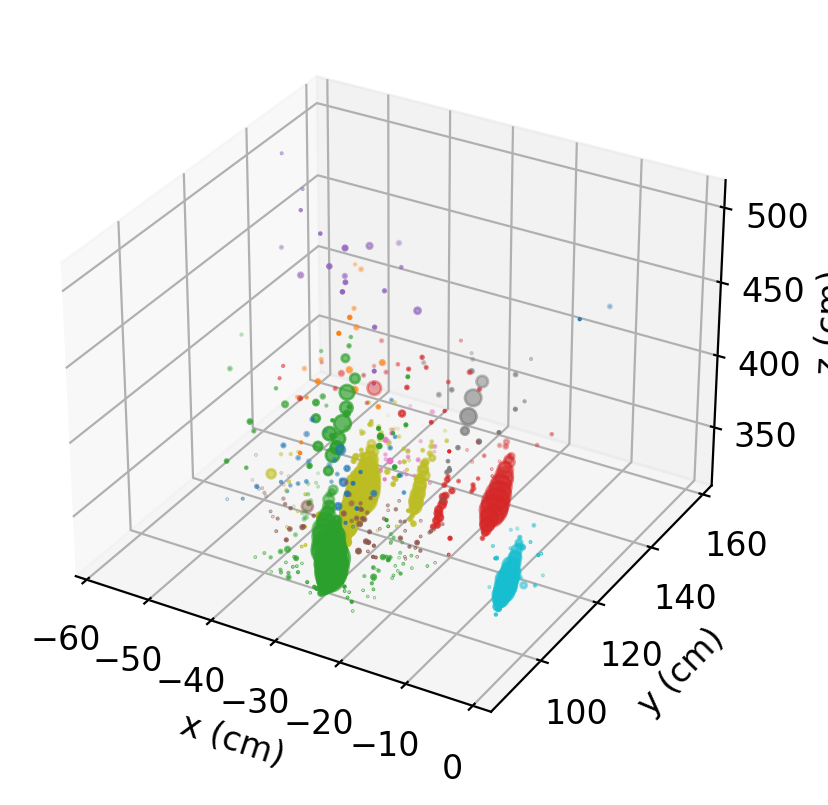

In [141]:
# kmeans on barycentres
def kmeans_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary, sample_weight=raw_e)
    return kmeans.labels_

labels = kmeans_bary(trackster_data, eid)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

#### LC level clustering

Running clustering on layerclusters - for comparison

Precision: 0.76, Recall: 0.12, F-score: 0.63


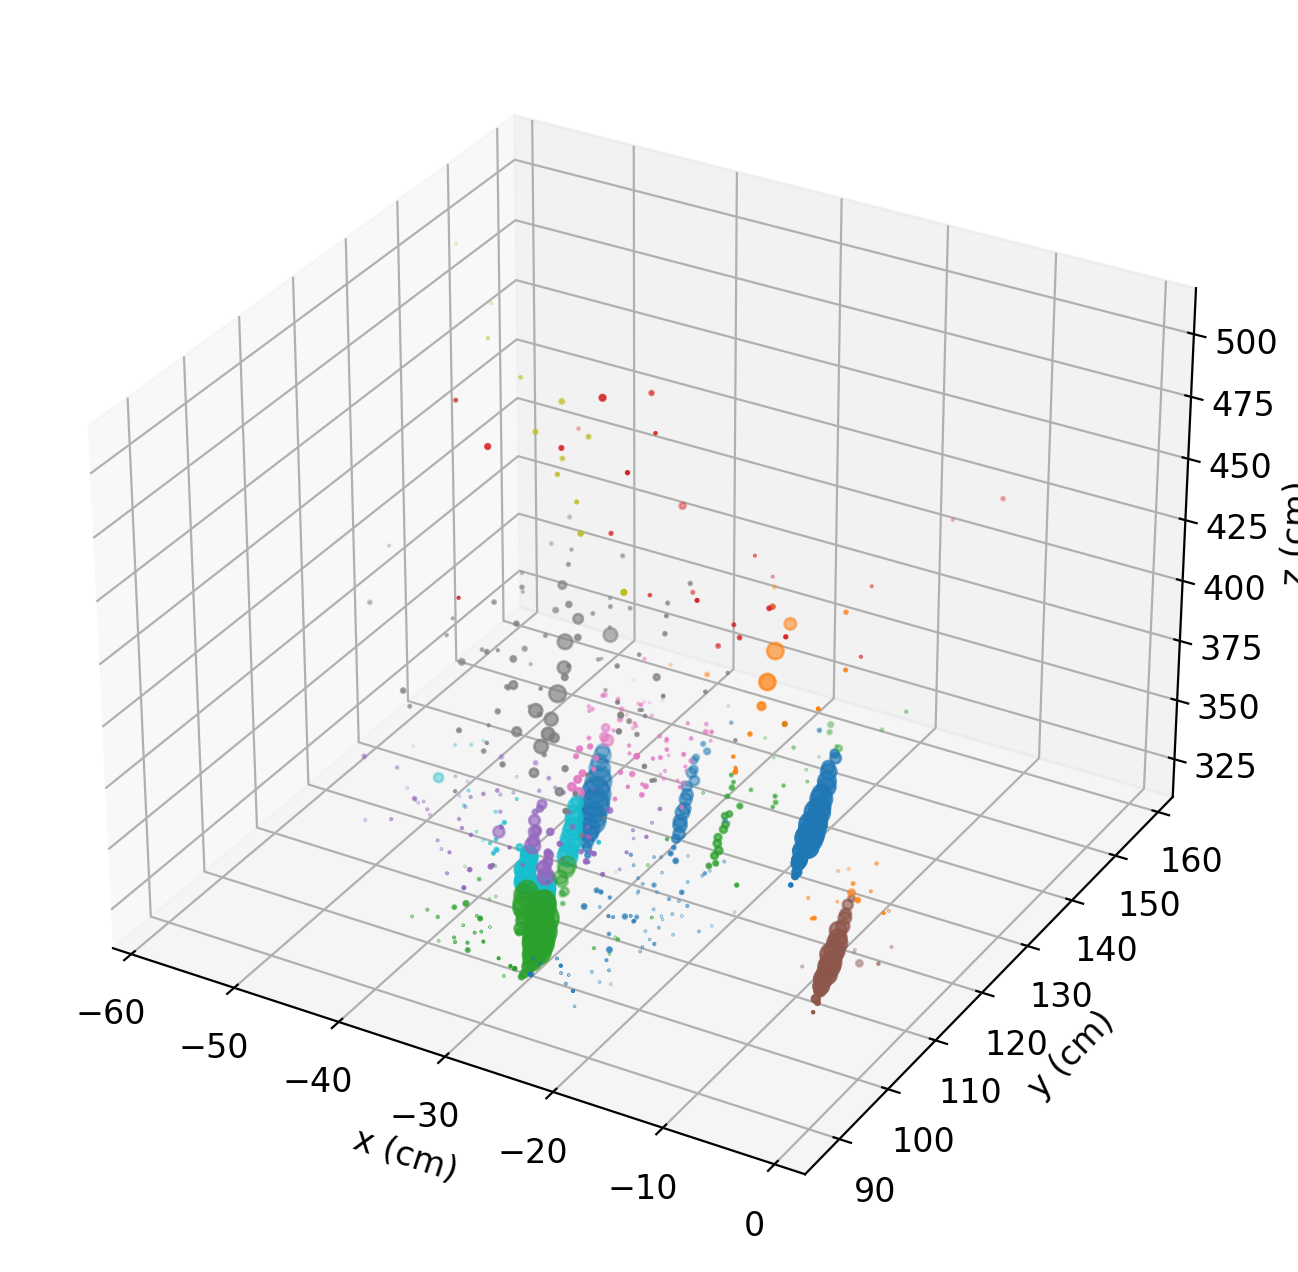

In [142]:
### Doesn really hehlp
K = sum(trackster_data["raw_energy"][eid] > 10)

X_vertices = get_lc_data(cluster_data, trackster_data, eid)
# kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)
# labels = kmeans.labels_
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_vertices)
labels = gmm.predict(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), labels)
re = remap_items_by_label(ak.flatten(t_energy), labels)
rm = remap_items_by_label(ak.flatten(t_multiplicity), labels)

precision, recall, fscore = evaluate(nhits, ri, st_indexes, re, st_energy, rm, st_multiplicity)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(t_x), labels)
ry = remap_items_by_label(ak.flatten(t_y), labels)
rz = remap_items_by_label(ak.flatten(t_z), labels)
re = remap_items_by_label(ak.flatten(t_energy), labels)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

### GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

In: 71 Out: 14 Precision: 0.77, Recall: 0.16, F-score: 0.67


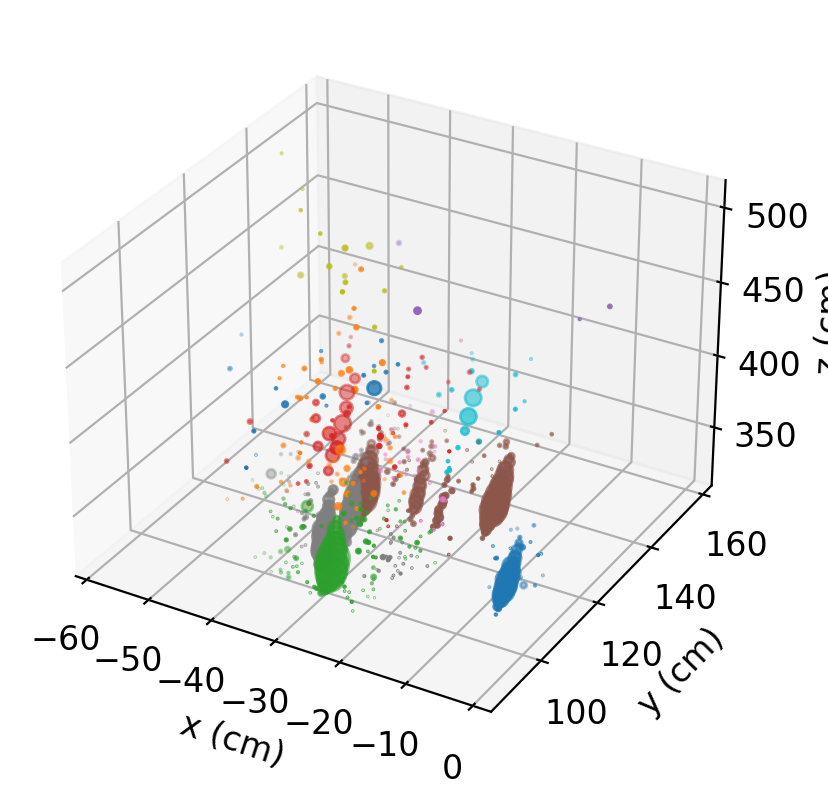

In [143]:
# kmeans on barycentres

def gmm_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)
    return gmm.predict(X_bary)

labels = gmm_bary(trackster_data, eid)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### DBSCAN

In: 71 Out: 8 Precision: 0.46, Recall: 0.37, F-score: 0.46


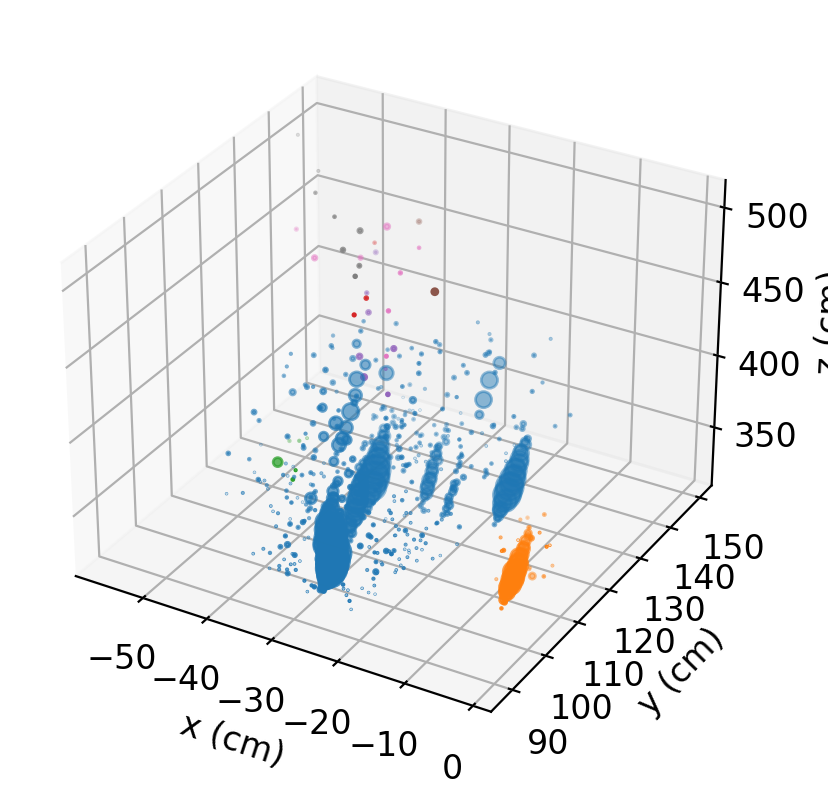

In [144]:
def dbscan_bary(_data, _eid, eps=2):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    dbscan = DBSCAN(eps=eps, min_samples=1).fit(X_bary, sample_weight=raw_e)
    return dbscan.labels_

labels = dbscan_bary(trackster_data, eid, eps=12)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### Meanshift

In: 71 Out: 28 Precision: 0.84, Recall: 0.13, F-score: 0.69


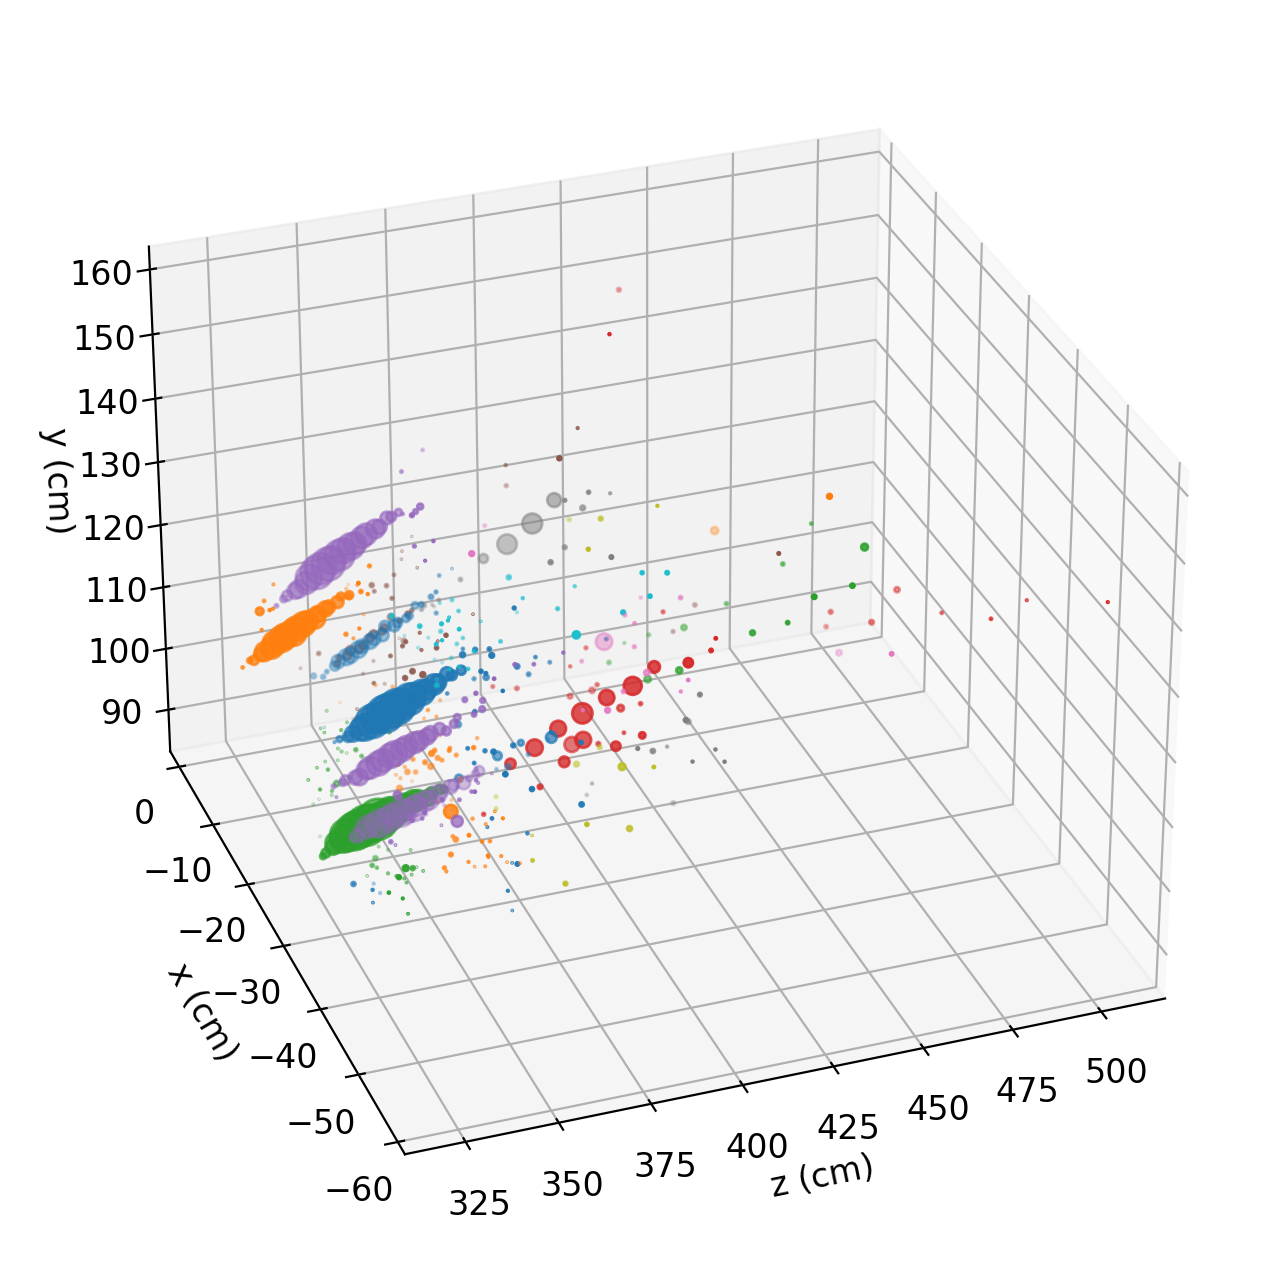

In [147]:
def meanshift_bary(_data, _eid, bandwidth=10):
    X_bary = get_bary_data(_data, _eid)
    ms = MeanShift(bandwidth=bandwidth).fit(X_bary)
    return ms.labels_

labels = meanshift_bary(trackster_data, eid, bandwidth=10)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection="3d")

ax.view_init(elev=30, azim=-110)

ax.set_xlabel("z (cm)")
ax.set_ylabel("x (cm)")
ax.set_zlabel("y (cm)")

for i, x, y, z, e in zip(range(len(r_x)), r_z, r_x, r_y, r_e):
    ax.scatter(x, y, z, s=np.array(e)*3)

fig.savefig('export/meanshift-multiparticle.png', dpi=300, bbox_inches='tight', transparent=True)


precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### Agglomerative

In: 15 Out: 7 Precision: 1.00, Recall: 0.21, F-score: 0.88


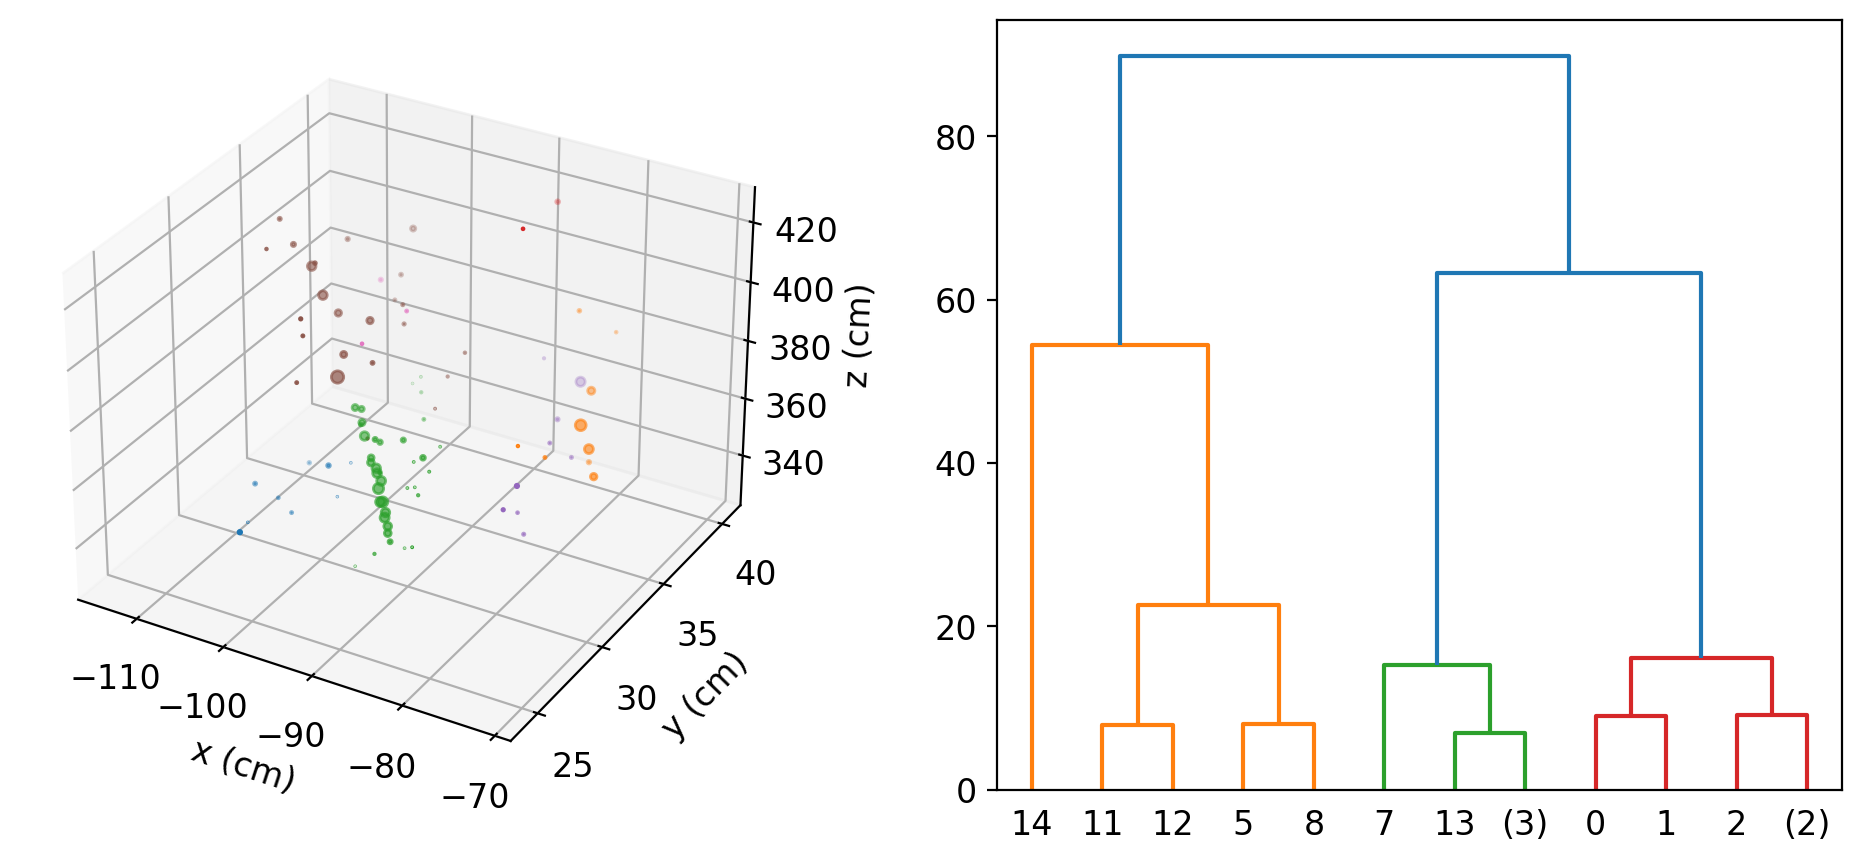

In [65]:
model = None
def agglomerative_bary(_data, _eid, distance_threshold=0):
    X_bary = get_bary_data(_data, _eid)
    global model
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None)
    model.fit(X_bary)
    return model.labels_

labels = agglomerative_bary(trackster_data, eid, distance_threshold=12)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

ax = fig.add_subplot(122)
plot_dendrogram(model, truncate_mode="level", p=3, ax=ax)

## Evaluations

In [67]:
results = []
nhits_ = cluster_data["cluster_number_of_hits"]
clusters_e_ = cluster_data["energy"]
t_multi_ = trackster_data["vertices_multiplicity"] 
st_multi_ = simtrackster_data["stsSC_vertices_multiplicity"]
t_indexes_ = trackster_data["vertices_indexes"]
st_indexes_ = simtrackster_data["stsSC_vertices_indexes"]

# get mean Precision, Recall and F-Score for the fill dataset
for eid in range(20):
    results.append((
        *evaluate(
            nhits_[eid],
            t_indexes_[eid],
            st_indexes_[eid],
            ak.Array([clusters_e_[eid][indices] for indices in t_indexes_[eid]]),
            ak.Array([clusters_e_[eid][indices] for indices in st_indexes_[eid]]),
            t_multi_[eid],
            st_multi_[eid]
        ),
        len(t_indexes_[eid])
    ))
in_mean = np.array(results).mean(axis=0)
in_mean.tolist()

[0.9745814129876773, 0.13879720051511246, 0.7688640677261327, 28.1]

In [79]:
res = {}
for eps in range(15, 25, 1):
    baseline_results = baseline_evaluation(
        agglomerative_bary,
        cluster_data,
        trackster_data,
        simtrackster_data,
        max_events=20,
        distance_threshold=eps
    )
    out_mean = np.array(baseline_results).mean(axis=0)
    res[eps] = out_mean
    diff = out_mean - in_mean
    print(eps, diff.astype(float).tolist())

15 [-0.009491612133215921, 0.09003826923971586, 0.0764708365770268, -16.25]
16 [-0.011689644760707663, 0.0958974807230864, 0.07912064242129524, -17.05]
17 [-0.01222636160324253, 0.1011970010420335, 0.08073726811855753, -17.400000000000002]
18 [-0.015528528838407274, 0.10929166512365304, 0.08245374528368199, -18.200000000000003]
19 [-0.02128622875312758, 0.11030658533830306, 0.08043459887798532, -18.6]
20 [-0.022745276926982028, 0.1130619630456145, 0.08073348027334049, -19.1]
21 [-0.02598377951135933, 0.11713992708375781, 0.08015772681750699, -19.55]
22 [-0.041756386985626115, 0.1234810825760923, 0.06767510072809557, -20.0]
23 [-0.04671822981936602, 0.12747130886067543, 0.06512879652723536, -20.3]
24 [-0.0469139976684434, 0.13144065736068217, 0.06613438182111564, -20.55]


In [17]:
in_mean.tolist()

[0.8338938647178699, 0.09655080833227747, 0.6325458392812311, 96.75]

In [80]:
res[18]

array([0.95905288, 0.24808887, 0.85131781, 9.9       ])

## Results

Idea: improvement in recall while recall is fixed: delta R + delta P

### Two-Pions


### Multiparticle
- Kmeans:
    - 6 [-0.056094432329274135, 0.11518087880560998, 0.06624320451034427, -72.8]
    - 7 [-0.05827751948781246, 0.13315511607248348, 0.07004951834743345, -75.1]
    - 8 [-0.061103979080629256, 0.14136411164799728, 0.07145326677568353, -77.25]
    - 9 [-0.07927879664884363, 0.1476275526765211, 0.058253647824212385, -79.15]
    - 10 [-0.08915074720748895, 0.15765147801667745, 0.05419572321952493, -80.4]
    - 11 [-0.09393172183633935, 0.16298912360232393, 0.051791684710546515, -81.55]
- GMM:
    - 2 [-0.008320824274908212, 0.03844648720876265, 0.045206572405240175, -32.85]
    - 3 [-0.0273230419266538, 0.0672409770825963, 0.057765548685057455, -49.7]
    - 4 [-0.057299489710070595, 0.08022478207990869, 0.04612774638393202, -60.35]
    - 5 [-0.06306543374245999, 0.10575231044073333, 0.0573799037624203, -68.0]
    - 6 [-0.08295232585347023, 0.1264686994404416, 0.04838983335861302, -72.8]
    - 7 [-0.09967533548527696, 0.13421835744087388, 0.0382283188620558, -75.1]
    - 8 [-0.1147867536335051, 0.13975096513639773, 0.02817427685529894, -77.25]
    - 9 [-0.13136355039762482, 0.15083302590252018, 0.015688528515837685, -79.15]
    - 10 [-0.1390461638952878, 0.1586693401196798, 0.012569604288789393, -80.4]

- DBSCAN:
    - 3 [-0.0005447814568254605, 0.000491351967586845, 0.0005927644080637728, -6.150000000000006]
    - 4 [-0.0013111444165468944, 0.0031610037557616294, 0.005500858038183232, -10.400000000000006]
    - 5 [-0.006699091475659835, 0.016207890970641875, 0.018388737919105558, -18.900000000000006]
    - 6 [-0.016263061060732498, 0.04065870573328645, 0.034980182204374044, -30.150000000000006]
    - 7 [-0.06238560380722469, 0.10496938180926585, 0.03673981299062368, -44.9]
    - 8 [-0.1138589849631293, 0.16577734176961512, 0.02433524107611007, -57.2]
    - 9 [-0.18247798223407286, 0.25933070756226045, -0.015396909634353584, -68.65]
    - 10 [-0.2503631488551027, 0.33788074531830536, -0.06643390897513035, -75.9]
- Meanshift
    - 5 [-0.0032552055468776375, 0.014424078126481762, 0.019307432314343398, -15.0]
    - 6 [-0.008793096889163854, 0.030932473213457684, 0.03419522017489951, -25.75]
    - 7 [-0.01833740859059796, 0.05697691200588373, 0.05228681372230215, -38.3]
    - 8 [-0.03151980806922494, 0.084537396247308, 0.0652767688231034, -49.8]
    - 9 [-0.04574216851587021, 0.1258176926843458, 0.07459772151592692, -59.65]
    - 10 [-0.06608735001355914, 0.14739522039044511, 0.06461518410292655, -66.05]
- Agglomerative
    - 8 [-0.010535621383213956, 0.03860879719659255, 0.04384662885998414, -33.6]
    - 9 [-0.012309655317853552, 0.04786835433564207, 0.05180442946717845, -40.1]
    - 10 [-0.015213838348089537, 0.0557665097595918, 0.05787735094527535, -44.9]
    - 11 [-0.02004173303043577, 0.06436172304324059, 0.06136618052826748, -49.0]
    - 12 [-0.022562697037554313, 0.06901814868975784, 0.06355289331450154, -52.55]
    - 13 [-0.028314953889539418, 0.07455572753563605, 0.0633021932815947, -55.6]
    - 12 [-0.022562697037554313, 0.06901814868975784, 0.06355289331450154, -52.55]
    - 13 [-0.028314953889539418, 0.07455572753563605, 0.0633021932815947, -55.6]
    - 14 [-0.03154343105126123, 0.07912543256673274, 0.06462173541917993, -57.8]
    - 15 [-0.036013514344579, 0.08472256658963948, 0.06339298056547515, -59.85]
    - 16 [-0.040277511898911156, 0.0884643138651798, 0.06351025463582516, -62.15]
    - 15 [-0.036013514344579, 0.08472256658963948, 0.06339298056547515, -59.85]
    - 16 [-0.040277511898911156, 0.0884643138651798, 0.06351025463582516, -62.15]
    - 17 [-0.04163925784044531, 0.0939155227555602, 0.06599095026100132, -63.9]
    - 18 [-0.04932592417244319, 0.09890505471563282, 0.06316285550500522, -65.8]
    - 19 [-0.052987925819247716, 0.10376144925473141, 0.06369954402339328, -67.45]
    - 20 [-0.05735939524252176, 0.10939449313123037, 0.06321683916249965, -69.0]
    - 21 [-0.062252642140042336, 0.11448260799802007, 0.0616106193386281, -70.4]
    - 22 [-0.06667487969293628, 0.12148872792056573, 0.060831126940181335, -71.8]
    - 23 [-0.07715470406171365, 0.12520451267359517, 0.0540433017331684, -73.05]


        